In [ ]:
import os
import sys
import re
from time import ctime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from collections import defaultdict
from IPython.display import display
from atlassian import Confluence
import dataframe_image as dfi
import gc

sys.path.append(r".\module")
import file_select
from file_select import SelectFilesButton

# Input Parameter

In [2]:
# parameter
result_path = 'postdefined'
image_source = 'postdefined'
folder_path = 'postdefined'

Confluence_Update_En = 'postdefined'
space_key = 'postdefined'
url = 'postdefined'
user_name = 'postdefined'
user_password = 'postdefined'

In [ ]:
# Parameters
result_path = "C:\\Users\\yeha1518\\dev\\python\\py_c4p_image_analysis\\Result"
image_source = "pattern"
folder_path = "D:\\C4PI IST_251204\\454"
Confluence_Update_En = 1
space_key = "~5244405"
parent_page_name = "Atlassian API Test"
url = "https://aries81.atlassian.net/wiki"
user_name = "fulu1268@gmail.com"
user_password = "xxx"

# Function

In [4]:
exp_spec = {
    "Min" : {"min":100, "unit":"DN"},
    "Mean" : {"min":120, "max":500, "unit":"DN"},
    "Max" : {"max":500, "unit":"DN"},
    "STD" : {"max":10, "unit":"DN"},
    "DSNU" : {"max":10, "unit":"DN"},
    "Col Variation" : {"max":0.5, "unit":"DN"},
    "Row Variation" : {"max":10, "unit":"DN"},
    "Hot Pixel Ratio" : {"max":0.01, "unit":"%"}
    }

In [5]:
def update_table(space, parent_id, page_id, title, head, contents):
    global confluence

    table = ''
    table += generate_row(head, True)

    for row in contents:
        table += generate_row(row, False)
    
    body = f"""{{excerpt}}
    {table}
    {{excerpt}}
    {{attachments}}
    """

    confluence.update_page(page_id, title, body=body, parent_id=parent_id, type='page', representation='wiki', always_update=False, minor_edit=True)

def generate_row(row_data, is_head=False):
    row = ''

    col_type = '||' if is_head else '|'
    row += col_type + col_type.join(row_data) + '\n'

    return row


def upload_image_in_table(space, page, img_path, image_size=250):
    img_name = img_path.split('\\')[-1]
    page_id = confluence.get_page_id(space, page)
    confluence.attach_file(img_path, page_id=page_id, content_type="image/png")
    img = f'!{img_name}|height={image_size}!'
    confluence.append_page(page_id, page, img, type='page', representation='wiki', minor_edit=True)

    return img

In [6]:
def line_count_diff(line_count, min_lines):
    # line이 동일한지 확인
    rows = []
    for name, lines in line_count.items():
        diff = lines - min_lines
    
        if diff == 0:
            status = "Same"
            diff_disp = "0"
        else:
            status = "Diff"
            diff_disp = f"+{diff}"
    
        rows.append({
            "Group": name,
            "Original Lines": lines,
            "Min Lines": min_lines,
            "Line Difference": diff_disp,
            "Status": status
        })
    
    return pd.DataFrame(rows)

def analyze_dark_image(img):
    result = {}
    result['Line Number'] = int(img.shape[0])
    result['Min'] = int(np.min(img))
    result['Mean'] = float(np.mean(img))
    result['Max'] = int(np.max(img))
    result['STD'] = float(np.std(img))
    result['DSNU'] = float(np.std(img - np.mean(img)))
    
    # Column Variation
    col_mean = np.mean(img, axis=1)
    result['Col Variation'] = float(np.std(col_mean))
    # Row Variation
    row_mean = np.mean(img, axis=0)
    result['Row Variation'] = float(np.std(row_mean))

    # Hot pixel
    threshold = img.mean() + 6 * img.std()
    hot_pixels = img > threshold
    result['Hot Pixel Ratio'] = float(np.sum(hot_pixels) / img.size)

    return result, row_mean

def check_grayshade_pattern(data, pattern_len=768, verbose=True):
    result = {}
    expected = np.arange(len(data)) % pattern_len
    mismatch = data != expected
    mismatch_cnt = np.count_nonzero(mismatch)

    print(f"[GLOBAL] {'PASS' if mismatch_cnt == 0 else 'FAIL'} | mismatch = {mismatch_cnt}")

    if mismatch_cnt > 0 and verbose:
        idx = np.where(mismatch)[0][:5]
        for i in idx:
            print(f"  idx {i} : actual={data[i]}, expected={expected[i]}")
        result["Line number"] = int(len(data)/(12288*2))
        result["Pattern Check"] = "Error"
        result["Pass"] = "FAIL"
    else:
        result["Line number"] = int(len(data)/(12288*2))
        result["Pattern Check"] = "No Error"
        result["Pass"] = "PASS"

    return result

def check_pass(measured, spec):
    if spec is None:
        return None

    if "min" in spec and measured < spec["min"]:
        return False
    if "max" in spec and measured > spec["max"]:
        return False

    return True

def format_measured(value):
    if isinstance(value, (int, np.integer)):
        return f"{value:d}"
    elif isinstance(value, (float, np.floating)):
        return f"{value:.2f}"
    else:
        return str(value)

def make_result_table(exp_spec, result):
    rows = []

    for metric, measured in result.items():
        spec = exp_spec.get(metric)

        # 기대값 문자열
        if spec is None:
            expected_str = "N/A"
        else:
            parts = []
            if "min" in spec:
                parts.append(f">= {spec['min']}")
            if "max" in spec:
                parts.append(f"<= {spec['max']}")
            expected_str = " & ".join(parts) + f" {spec.get('unit','')}"

        rows.append({
            "Metric": metric,
            "Measured": format_measured(measured),
            "Expected": expected_str,
            "Pass": (
                "PASS" if check_pass(measured, spec)
                else "FAIL" if check_pass(measured, spec) is False
                else "-"
            )
        })

    return pd.DataFrame(rows)

def make_result_table_pattern(result):
    rows = []

    for metric, measured in result.items():
        rows.append({
            "Metric": metric,
            "Measured": measured
        })

    return pd.DataFrame(rows)

def find_raw_files(folder_path):
    folder = Path(folder_path)
    return sorted(folder.rglob("*.raw"))

def reshape_2d(merged_data):
    cols = 6144
    rows = int(len(merged_data)/6144)
    return merged_data.reshape((rows,cols))

def merge_raw_numpy(files, dtype='>u2'):
    chunks = []
    for idx, path in files:
        data = np.fromfile(path, dtype=dtype)
        chunks.append(data)
    return np.concatenate(chunks)

def highlight_fail(val):
    if val == "FAIL":
        return "color: red; font-weight: bold"
    return ""

# File Parsing

In [7]:
raw_files = find_raw_files(folder_path)

In [8]:
scenario_id = Path(raw_files[0]).parent.name
scenario_id

'454'

In [9]:
# Time Tag
t_str = ctime()
t_str = t_str.replace("  ", "")
t_str = t_str.replace(":", "_")
t_str = t_str.replace(" ", "_")
#make folder
# result_path = "//Result"
# result_path = r'D:\dev\python\c4p\py_c4p_image_analysis\Result'
folder_name = f"{scenario_id}_Image_Analysis_{t_str}"
folder_address = f"{result_path}\\{folder_name}"
os.mkdir(folder_address)
folder_address

'C:\\Users\\yeha1518\\dev\\python\\py_c4p_image_analysis\\Result\\454_Image_Analysis_Sun_Dec_21_13_17_16_2025'

In [10]:
# 파일명 패턴
pattern = re.compile(r'(MS\d+_\d)_(\d{5})\.raw$')
groups = defaultdict(list)

In [11]:
# 그룹핑
for p in raw_files:
    name = Path(p).name
    m = pattern.match(name)
    if not m:
        continue
    group_name = m.group(1)        # MS0_0, MS1_3 ...
    index = int(m.group(2))        # 1, 2, ...
    groups[group_name].append((index, p))

# MS0

In [12]:
# file merge
dtype = '>u2'
for group_name in sorted(groups.keys()):
    files = groups[group_name]
    # index 순서대로 정렬
    files.sort(key=lambda x: x[0])
    # print(f'\n[{group_name}]')
    merged_bytes = bytearray()
    if (group_name == "MS0_0"):
        ms0_0_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS0_1"):
        ms0_1_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS0_2"):
        ms0_2_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS0_3"):
        ms0_3_merged = merge_raw_numpy(files,dtype)

In [13]:
# 2D 배열로 reshape
ms0_0_merged_re = reshape_2d(ms0_0_merged)
ms0_1_merged_re = reshape_2d(ms0_1_merged)
ms0_2_merged_re = reshape_2d(ms0_2_merged)
ms0_3_merged_re = reshape_2d(ms0_3_merged)

ms0_line_count = {}
ms0_line_count["ms0:0"] = int(ms0_0_merged_re.shape[0])
ms0_line_count["ms0:1"] = int(ms0_1_merged_re.shape[0])
ms0_line_count["ms0:2"] = int(ms0_2_merged_re.shape[0])
ms0_line_count["ms0:3"] = int(ms0_3_merged_re.shape[0])
ms0_min_lines = min(ms0_line_count.values())

ms0_0_merged_re = ms0_0_merged_re[:ms0_min_lines,:]
ms0_1_merged_re = ms0_1_merged_re[:ms0_min_lines,:]
ms0_2_merged_re = ms0_2_merged_re[:ms0_min_lines,:]
ms0_3_merged_re = ms0_3_merged_re[:ms0_min_lines,:]

del ms0_0_merged
del ms0_1_merged
del ms0_2_merged
del ms0_3_merged
gc.collect()

20

In [14]:
ms0_line_diff = line_count_diff(ms0_line_count,ms0_min_lines)

result_name = f"ms0_{scenario_id}_line_diff"
ms0_line_diff_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms0_line_diff, ms0_line_diff_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')

ms0_line_diff

,Group,Original Lines,Min Lines,Line Difference,Status
0,ms0:0,38992,38992,0,Same
1,ms0:1,38992,38992,0,Same
2,ms0:2,38992,38992,0,Same
3,ms0:3,38992,38992,0,Same


In [15]:
# 상하반전
ms0_2_merged_re_flip = np.flipud(ms0_2_merged_re)
ms0_3_merged_re_flip = np.flipud(ms0_3_merged_re)

In [16]:
# 배열합치기
ms0_merged_1 = np.concatenate([ms0_0_merged_re, ms0_1_merged_re],axis=1)
ms0_merged_2 = np.concatenate([ms0_2_merged_re_flip, ms0_3_merged_re_flip],axis=1)
del ms0_0_merged_re
del ms0_1_merged_re
del ms0_2_merged_re
del ms0_3_merged_re
del ms0_2_merged_re_flip
del ms0_3_merged_re_flip
gc.collect()

1505

In [17]:
# 배열합치기(FPA1+FPA2)
ms0_merged = np.concatenate([ms0_merged_1, ms0_merged_2],axis=1)
del ms0_merged_1
del ms0_merged_2
gc.collect()

0

In [18]:
if (image_source == "image"):
    ms0_result, ms0_row_mean = analyze_dark_image(ms0_merged)
    ms0_result_table = make_result_table(exp_spec, ms0_result)
else:
    ms0_result = check_grayshade_pattern(ms0_merged.ravel())
    ms0_row_mean = np.mean(ms0_merged, axis=0)
    ms0_result_table = make_result_table_pattern(ms0_result)

[GLOBAL] PASS | mismatch = 0


In [19]:
result_name = f"ms0_{scenario_id}_result"
ms0_result_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms0_result_table, ms0_result_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')
if (image_source == "image"):
    ms0_result_table.style.map(highlight_fail, subset=["Pass"])
else:
    ms0_result_table
ms0_result_table

,Metric,Measured
0,Line number,38992
1,Pattern Check,No Error
2,Pass,PASS


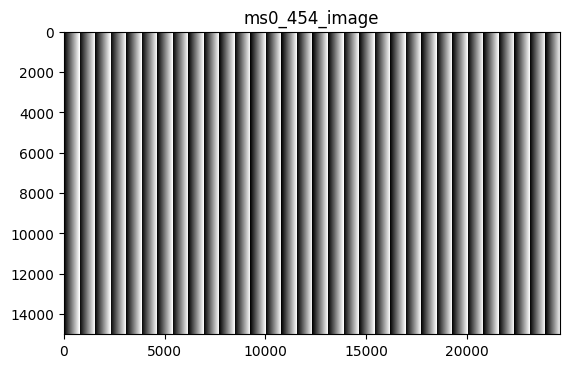

In [20]:
# 2D image
plt.figure()
plt.imshow(X=ms0_merged[:15000,:], cmap=plt.cm.gray, norm=None, aspect=None, interpolation='nearest',alpha=None, vmin=None, vmax=None, origin=None, extent=None)
title_name = f"ms0_{scenario_id}_image"
plt.title(title_name)
ms0_imshow_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms0_imshow_path, bbox_inches='tight')
plt.show()
plt.close()

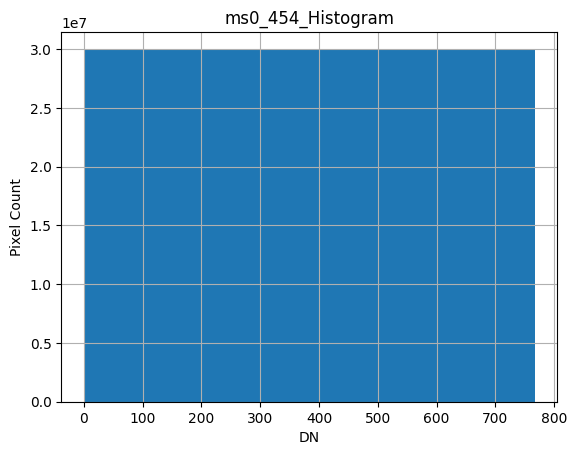

In [21]:
# histogram
plt.figure()
plt.hist(ms0_merged.ravel(),bins=32) # ravel함수 2D --> 1D, flatten()을 사용할수도 있음
plt.xlabel("DN")
plt.ylabel("Pixel Count")
title_name = f"ms0_{scenario_id}_Histogram"
plt.title(title_name)
ms0_hist_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms0_hist_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

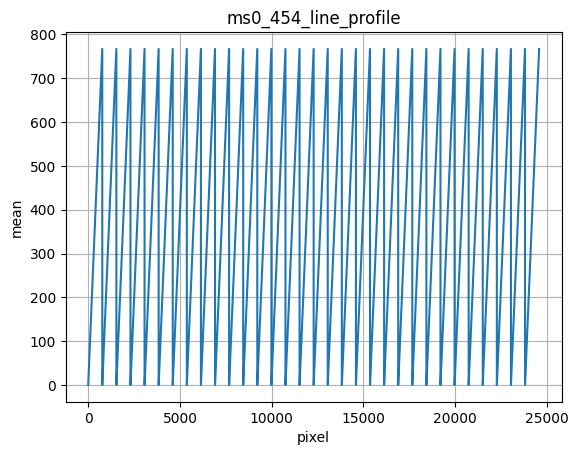

In [22]:
# Line profile
plt.figure()
plt.plot(ms0_row_mean)
plt.xlabel("pixel")
plt.ylabel("mean")
# plt.ylim(100,200)
title_name = f"ms0_{scenario_id}_line_profile" 
plt.title(title_name)
ms0_line_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms0_line_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

In [23]:
del ms0_merged
gc.collect()

11498

# MS1

In [24]:
# file merge
dtype = '>u2'
for group_name in sorted(groups.keys()):
    files = groups[group_name]
    # index 순서대로 정렬
    files.sort(key=lambda x: x[0])
    # print(f'\n[{group_name}]')
    merged_bytes = bytearray()
    if (group_name == "MS1_0"):
        ms1_0_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS1_1"):
        ms1_1_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS1_2"):
        ms1_2_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS1_3"):
        ms1_3_merged = merge_raw_numpy(files,dtype)

In [25]:
# 2D 배열로 reshape
ms1_0_merged_re = reshape_2d(ms1_0_merged)
ms1_1_merged_re = reshape_2d(ms1_1_merged)
ms1_2_merged_re = reshape_2d(ms1_2_merged)
ms1_3_merged_re = reshape_2d(ms1_3_merged)

ms1_line_count = {}
ms1_line_count["ms1:0"] = int(ms1_0_merged_re.shape[0])
ms1_line_count["ms1:1"] = int(ms1_1_merged_re.shape[0])
ms1_line_count["ms1:2"] = int(ms1_2_merged_re.shape[0])
ms1_line_count["ms1:3"] = int(ms1_3_merged_re.shape[0])
ms1_min_lines = min(ms1_line_count.values())

ms1_0_merged_re = ms1_0_merged_re[:ms1_min_lines,:]
ms1_1_merged_re = ms1_1_merged_re[:ms1_min_lines,:]
ms1_2_merged_re = ms1_2_merged_re[:ms1_min_lines,:]
ms1_3_merged_re = ms1_3_merged_re[:ms1_min_lines,:]

del ms1_0_merged
del ms1_1_merged
del ms1_2_merged
del ms1_3_merged
gc.collect()

0

In [26]:
ms1_line_diff = line_count_diff(ms1_line_count,ms1_min_lines)

result_name = f"ms1_{scenario_id}_line_diff"
ms1_line_diff_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms1_line_diff, ms1_line_diff_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')

ms1_line_diff

,Group,Original Lines,Min Lines,Line Difference,Status
0,ms1:0,38992,38984,+8,Diff
1,ms1:1,38984,38984,0,Same
2,ms1:2,38992,38984,+8,Diff
3,ms1:3,38984,38984,0,Same


In [27]:
# 상하반전
ms1_2_merged_re_flip = np.flipud(ms1_2_merged_re)
ms1_3_merged_re_flip = np.flipud(ms1_3_merged_re)

In [28]:
# 배열합치기
ms1_merged_1 = np.concatenate([ms1_0_merged_re, ms1_1_merged_re],axis=1)
ms1_merged_2 = np.concatenate([ms1_2_merged_re_flip, ms1_3_merged_re_flip],axis=1)
del ms1_0_merged_re
del ms1_1_merged_re
del ms1_2_merged_re
del ms1_3_merged_re
del ms1_2_merged_re_flip
del ms1_3_merged_re_flip
gc.collect()

1527

In [29]:
# 배열합치기(FPA1+FPA2)
ms1_merged = np.concatenate([ms1_merged_1, ms1_merged_2],axis=1)
del ms1_merged_1
del ms1_merged_2
gc.collect()

0

In [30]:
if (image_source == "image"):
    ms1_result, ms1_row_mean = analyze_dark_image(ms1_merged)
    ms1_result_table = make_result_table(exp_spec, ms1_result)
else:
    ms1_result = check_grayshade_pattern(ms1_merged.ravel())
    ms1_row_mean = np.mean(ms1_merged, axis=0)
    ms1_result_table = make_result_table_pattern(ms1_result)

[GLOBAL] PASS | mismatch = 0


In [31]:
result_name = f"ms1_{scenario_id}_result"
ms1_result_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms1_result_table, ms1_result_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')
if (image_source == "image"):
    ms1_result_table.style.map(highlight_fail, subset=["Pass"])
else:
    ms1_result_table
ms1_result_table

,Metric,Measured
0,Line number,38984
1,Pattern Check,No Error
2,Pass,PASS


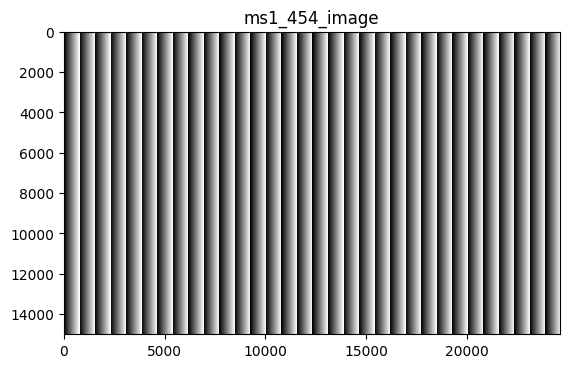

In [32]:
# 2D image
plt.figure()
plt.imshow(X=ms1_merged[:15000,:], cmap=plt.cm.gray, norm=None, aspect=None, interpolation='nearest',alpha=None, vmin=None, vmax=None, origin=None, extent=None)
title_name = f"ms1_{scenario_id}_image"
plt.title(title_name)
ms1_imshow_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms1_imshow_path, bbox_inches='tight')
plt.show()
plt.close()

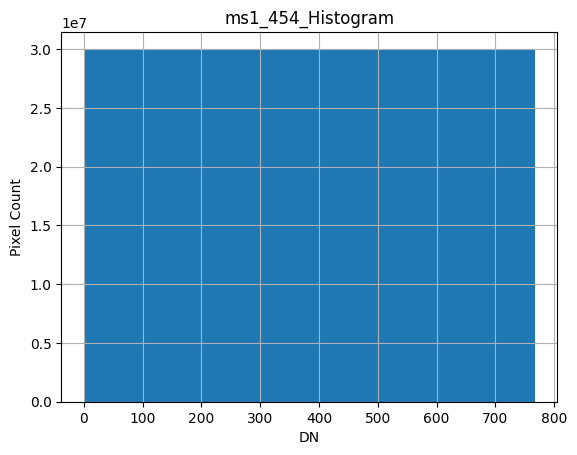

In [33]:
# histogram
plt.figure()
plt.hist(ms1_merged.ravel(),bins=32) # ravel함수 2D --> 1D, flatten()을 사용할수도 있음
plt.xlabel("DN")
plt.ylabel("Pixel Count")
title_name = f"ms1_{scenario_id}_Histogram"
plt.title(title_name)
ms1_hist_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms1_hist_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

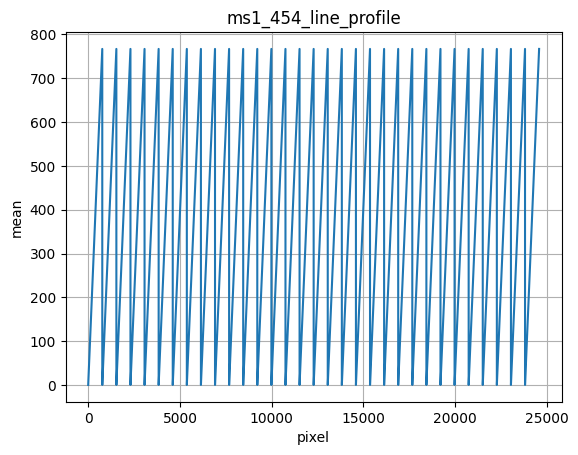

In [34]:
# Line profile
plt.figure()
plt.plot(ms1_row_mean)
plt.xlabel("pixel")
plt.ylabel("mean")
# plt.ylim(100,200)
title_name = f"ms1_{scenario_id}_line_profile"
plt.title(title_name)
ms1_line_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms1_line_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

In [35]:
del ms1_merged
gc.collect()

11492

# MS2

In [36]:
# file merge
dtype = '>u2'
for group_name in sorted(groups.keys()):
    files = groups[group_name]
    # index 순서대로 정렬
    files.sort(key=lambda x: x[0])
    # print(f'\n[{group_name}]')
    merged_bytes = bytearray()
    if (group_name == "MS2_0"):
        ms2_0_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS2_1"):
        ms2_1_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS2_2"):
        ms2_2_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS2_3"):
        ms2_3_merged = merge_raw_numpy(files,dtype)

In [37]:
# 2D 배열로 reshape
ms2_0_merged_re = reshape_2d(ms2_0_merged)
ms2_1_merged_re = reshape_2d(ms2_1_merged)
ms2_2_merged_re = reshape_2d(ms2_2_merged)
ms2_3_merged_re = reshape_2d(ms2_3_merged)

ms2_line_count = {}
ms2_line_count["ms2:0"] = int(ms2_0_merged_re.shape[0])
ms2_line_count["ms2:1"] = int(ms2_1_merged_re.shape[0])
ms2_line_count["ms2:2"] = int(ms2_2_merged_re.shape[0])
ms2_line_count["ms2:3"] = int(ms2_3_merged_re.shape[0])
ms2_min_lines = min(ms2_line_count.values())

ms2_0_merged_re = ms2_0_merged_re[:ms2_min_lines,:]
ms2_1_merged_re = ms2_1_merged_re[:ms2_min_lines,:]
ms2_2_merged_re = ms2_2_merged_re[:ms2_min_lines,:]
ms2_3_merged_re = ms2_3_merged_re[:ms2_min_lines,:]

del ms2_0_merged
del ms2_1_merged
del ms2_2_merged
del ms2_3_merged
gc.collect()

0

In [38]:
ms2_line_diff = line_count_diff(ms2_line_count,ms2_min_lines)

result_name = f"ms2_{scenario_id}_line_diff"
ms2_line_diff_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms2_line_diff, ms2_line_diff_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')

ms2_line_diff

,Group,Original Lines,Min Lines,Line Difference,Status
0,ms2:0,38992,38992,0,Same
1,ms2:1,38992,38992,0,Same
2,ms2:2,38992,38992,0,Same
3,ms2:3,38992,38992,0,Same


In [39]:
# 상하반전
ms2_2_merged_re_flip = np.flipud(ms2_2_merged_re)
ms2_3_merged_re_flip = np.flipud(ms2_3_merged_re)

In [40]:
# 배열합치기
ms2_merged_1 = np.concatenate([ms2_0_merged_re, ms2_1_merged_re],axis=1)
ms2_merged_2 = np.concatenate([ms2_2_merged_re_flip, ms2_3_merged_re_flip],axis=1)
del ms2_0_merged_re
del ms2_1_merged_re
del ms2_2_merged_re
del ms2_3_merged_re
del ms2_2_merged_re_flip
del ms2_3_merged_re_flip
gc.collect()

1525

In [41]:
# 배열합치기(FPA1+FPA2)
ms2_merged = np.concatenate([ms2_merged_1, ms2_merged_2],axis=1)
del ms2_merged_1
del ms2_merged_2
gc.collect()

0

In [42]:
if (image_source == "image"):
    ms2_result, ms2_row_mean = analyze_dark_image(ms2_merged)
    ms2_result_table = make_result_table(exp_spec, ms2_result)
else:
    ms2_result = check_grayshade_pattern(ms2_merged.ravel())
    ms2_row_mean = np.mean(ms2_merged, axis=0)
    ms2_result_table = make_result_table_pattern(ms2_result)

[GLOBAL] PASS | mismatch = 0


In [43]:
result_name = f"ms2_{scenario_id}_result"
ms2_result_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms2_result_table, ms2_result_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')
if (image_source == "image"):
    ms2_result_table.style.map(highlight_fail, subset=["Pass"])
else:
    ms2_result_table
ms2_result_table

,Metric,Measured
0,Line number,38992
1,Pattern Check,No Error
2,Pass,PASS


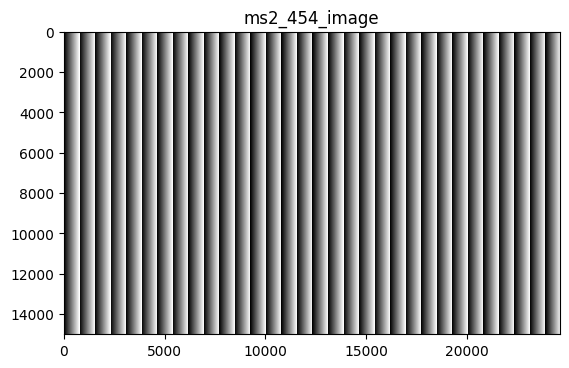

In [44]:
# 2D image
plt.figure()
plt.imshow(X=ms2_merged[:15000,:], cmap=plt.cm.gray, norm=None, aspect=None, interpolation='nearest',alpha=None, vmin=None, vmax=None, origin=None, extent=None)
title_name = f"ms2_{scenario_id}_image"
plt.title(title_name)
ms2_imshow_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms2_imshow_path, bbox_inches='tight')
plt.show()
plt.close()

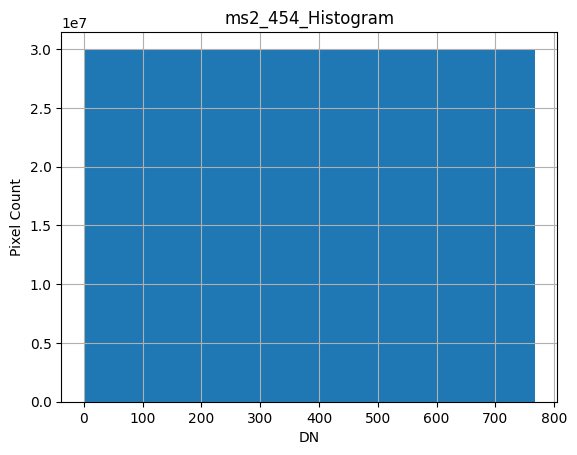

In [45]:
# histogram
plt.figure()
plt.hist(ms2_merged.ravel(),bins=32) # ravel함수 2D --> 1D, flatten()을 사용할수도 있음
plt.xlabel("DN")
plt.ylabel("Pixel Count")
title_name = f"ms2_{scenario_id}_Histogram"
plt.title(title_name)
ms2_hist_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms2_hist_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

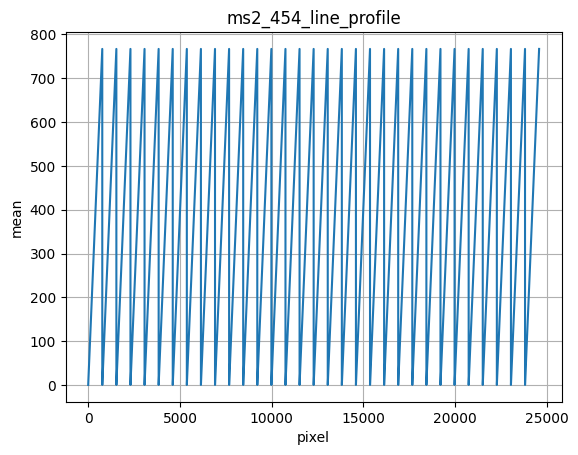

In [46]:
# Line profile
plt.figure()
plt.plot(ms2_row_mean)
plt.xlabel("pixel")
plt.ylabel("mean")
# plt.ylim(100,200)
title_name = f"ms2_{scenario_id}_line_profile"
plt.title(title_name)
ms2_line_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms2_line_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

In [47]:
del ms2_merged
gc.collect()

11498

# MS3

In [48]:
# file merge
dtype = '>u2'
for group_name in sorted(groups.keys()):
    files = groups[group_name]
    # index 순서대로 정렬
    files.sort(key=lambda x: x[0])
    # print(f'\n[{group_name}]')
    merged_bytes = bytearray()
    if (group_name == "MS3_0"):
        ms3_0_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS3_1"):
        ms3_1_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS3_2"):
        ms3_2_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS3_3"):
        ms3_3_merged = merge_raw_numpy(files,dtype)

In [49]:
# 2D 배열로 reshape
ms3_0_merged_re = reshape_2d(ms3_0_merged)
ms3_1_merged_re = reshape_2d(ms3_1_merged)
ms3_2_merged_re = reshape_2d(ms3_2_merged)
ms3_3_merged_re = reshape_2d(ms3_3_merged)

ms3_line_count = {}
ms3_line_count["ms3:0"] = int(ms3_0_merged_re.shape[0])
ms3_line_count["ms3:1"] = int(ms3_1_merged_re.shape[0])
ms3_line_count["ms3:2"] = int(ms3_2_merged_re.shape[0])
ms3_line_count["ms3:3"] = int(ms3_3_merged_re.shape[0])
ms3_min_lines = min(ms3_line_count.values())

ms3_0_merged_re = ms3_0_merged_re[:ms3_min_lines,:]
ms3_1_merged_re = ms3_1_merged_re[:ms3_min_lines,:]
ms3_2_merged_re = ms3_2_merged_re[:ms3_min_lines,:]
ms3_3_merged_re = ms3_3_merged_re[:ms3_min_lines,:]

del ms3_0_merged
del ms3_1_merged
del ms3_2_merged
del ms3_3_merged
gc.collect()

0

In [50]:
ms3_line_diff = line_count_diff(ms3_line_count,ms3_min_lines)

result_name = f"ms3_{scenario_id}_line_diff"
ms3_line_diff_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms3_line_diff, ms3_line_diff_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')

ms3_line_diff

,Group,Original Lines,Min Lines,Line Difference,Status
0,ms3:0,38992,38992,0,Same
1,ms3:1,38992,38992,0,Same
2,ms3:2,38992,38992,0,Same
3,ms3:3,38992,38992,0,Same


In [51]:
# 상하반전
ms3_2_merged_re_flip = np.flipud(ms3_2_merged_re)
ms3_3_merged_re_flip = np.flipud(ms3_3_merged_re)

In [52]:
# 배열합치기
ms3_merged_1 = np.concatenate([ms3_0_merged_re, ms3_1_merged_re],axis=1)
ms3_merged_2 = np.concatenate([ms3_2_merged_re_flip, ms3_3_merged_re_flip],axis=1)
del ms3_0_merged_re
del ms3_1_merged_re
del ms3_2_merged_re
del ms3_3_merged_re
del ms3_2_merged_re_flip
del ms3_3_merged_re_flip
gc.collect()

1525

In [53]:
# 배열합치기(FPA1+FPA2)
ms3_merged = np.concatenate([ms3_merged_1, ms3_merged_2],axis=1)
del ms3_merged_1
del ms3_merged_2
gc.collect()

0

In [54]:
if (image_source == "image"):
    ms3_result, ms3_row_mean = analyze_dark_image(ms3_merged)
    ms3_result_table = make_result_table(exp_spec, ms3_result)
else:
    ms3_result = check_grayshade_pattern(ms3_merged.ravel())
    ms3_row_mean = np.mean(ms3_merged, axis=0)
    ms3_result_table = make_result_table_pattern(ms3_result)

[GLOBAL] PASS | mismatch = 0


In [55]:
result_name = f"ms3_{scenario_id}_result"
ms3_result_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms3_result_table, ms3_result_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')
if (image_source == "image"):
    ms3_result_table.style.map(highlight_fail, subset=["Pass"])
else:
    ms3_result_table
ms3_result_table

,Metric,Measured
0,Line number,38992
1,Pattern Check,No Error
2,Pass,PASS


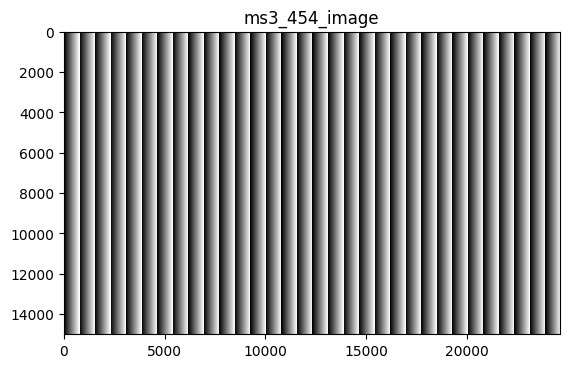

In [56]:
# 2D image
plt.figure()
plt.imshow(X=ms3_merged[:15000,:], cmap=plt.cm.gray, norm=None, aspect=None, interpolation='nearest',alpha=None, vmin=None, vmax=None, origin=None, extent=None)
title_name = f"ms3_{scenario_id}_image"
plt.title(title_name)
ms3_imshow_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms3_imshow_path, bbox_inches='tight')
plt.show()
plt.close()

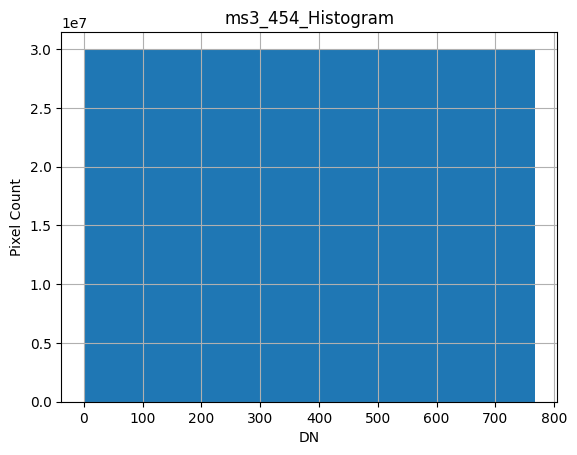

In [57]:
# histogram
plt.figure()
plt.hist(ms3_merged.ravel(),bins=32) # ravel함수 2D --> 1D, flatten()을 사용할수도 있음
plt.xlabel("DN")
plt.ylabel("Pixel Count")
title_name = f"ms3_{scenario_id}_Histogram"
plt.title(title_name)
ms3_hist_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms3_hist_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

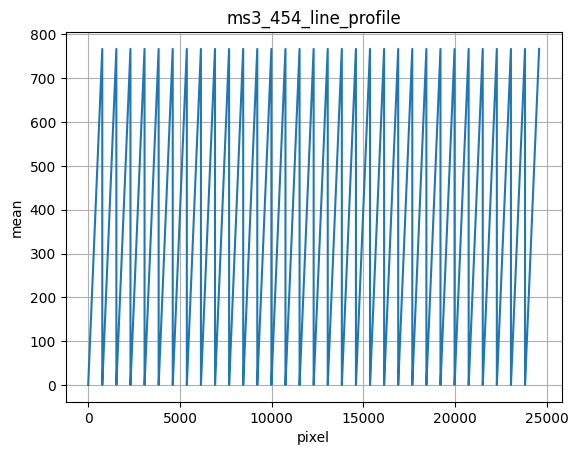

In [58]:
# Line profile
plt.figure()
plt.plot(ms3_row_mean)
plt.xlabel("pixel")
plt.ylabel("mean")
# plt.ylim(100,200)
title_name = f"ms3_{scenario_id}_line_profile"
plt.title(title_name)
ms3_line_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms3_line_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

In [59]:
del ms3_merged
gc.collect()

11498

# MS4

In [60]:
# file merge
dtype = '>u2'
for group_name in sorted(groups.keys()):
    files = groups[group_name]
    # index 순서대로 정렬
    files.sort(key=lambda x: x[0])
    # print(f'\n[{group_name}]')
    merged_bytes = bytearray()
    if (group_name == "MS4_0"):
        ms4_0_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS4_1"):
        ms4_1_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS4_2"):
        ms4_2_merged = merge_raw_numpy(files,dtype)
    elif (group_name == "MS4_3"):
        ms4_3_merged = merge_raw_numpy(files,dtype)

In [61]:
# 2D 배열로 reshape
ms4_0_merged_re = reshape_2d(ms4_0_merged)
ms4_1_merged_re = reshape_2d(ms4_1_merged)
ms4_2_merged_re = reshape_2d(ms4_2_merged)
ms4_3_merged_re = reshape_2d(ms4_3_merged)

ms4_line_count = {}
ms4_line_count["ms4:0"] = int(ms4_0_merged_re.shape[0])
ms4_line_count["ms4:1"] = int(ms4_1_merged_re.shape[0])
ms4_line_count["ms4:2"] = int(ms4_2_merged_re.shape[0])
ms4_line_count["ms4:3"] = int(ms4_3_merged_re.shape[0])
ms4_min_lines = min(ms4_line_count.values())

ms4_0_merged_re = ms4_0_merged_re[:ms4_min_lines,:]
ms4_1_merged_re = ms4_1_merged_re[:ms4_min_lines,:]
ms4_2_merged_re = ms4_2_merged_re[:ms4_min_lines,:]
ms4_3_merged_re = ms4_3_merged_re[:ms4_min_lines,:]

del ms4_0_merged
del ms4_1_merged
del ms4_2_merged
del ms4_3_merged
gc.collect()

0

In [62]:
ms4_line_diff = line_count_diff(ms4_line_count,ms4_min_lines)

result_name = f"ms4_{scenario_id}_line_diff"
ms4_line_diff_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms4_line_diff, ms4_line_diff_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')

ms4_line_diff

,Group,Original Lines,Min Lines,Line Difference,Status
0,ms4:0,38992,38984,+8,Diff
1,ms4:1,38984,38984,0,Same
2,ms4:2,38992,38984,+8,Diff
3,ms4:3,38984,38984,0,Same


In [63]:
# 상하반전
ms4_2_merged_re_flip = np.flipud(ms4_2_merged_re)
ms4_3_merged_re_flip = np.flipud(ms4_3_merged_re)

In [64]:
# 배열합치기
ms4_merged_1 = np.concatenate([ms4_0_merged_re, ms4_1_merged_re],axis=1)
ms4_merged_2 = np.concatenate([ms4_2_merged_re_flip, ms4_3_merged_re_flip],axis=1)
del ms4_0_merged_re
del ms4_1_merged_re
del ms4_2_merged_re
del ms4_3_merged_re
del ms4_2_merged_re_flip
del ms4_3_merged_re_flip
gc.collect()

1527

In [65]:
# 배열합치기(FPA1+FPA2)
ms4_merged = np.concatenate([ms4_merged_1, ms4_merged_2],axis=1)
del ms4_merged_1
del ms4_merged_2
gc.collect()

0

In [66]:
if (image_source == "image"):
    ms4_result, ms4_row_mean = analyze_dark_image(ms4_merged)
    ms4_result_table = make_result_table(exp_spec, ms4_result)
else:
    ms4_result = check_grayshade_pattern(ms4_merged.ravel())
    ms4_row_mean = np.mean(ms4_merged, axis=0)
    ms4_result_table = make_result_table_pattern(ms4_result)

[GLOBAL] PASS | mismatch = 0


In [67]:
result_name = f"ms4_{scenario_id}_result"
ms4_result_path = folder_address + '\\'+ result_name + '.png'
dfi.export(ms4_result_table, ms4_result_path, max_cols=-1, max_rows=-1,table_conversion='matplotlib')
if (image_source == "image"):
    ms4_result_table.style.map(highlight_fail, subset=["Pass"])
else:
    ms4_result_table
ms4_result_table

,Metric,Measured
0,Line number,38984
1,Pattern Check,No Error
2,Pass,PASS


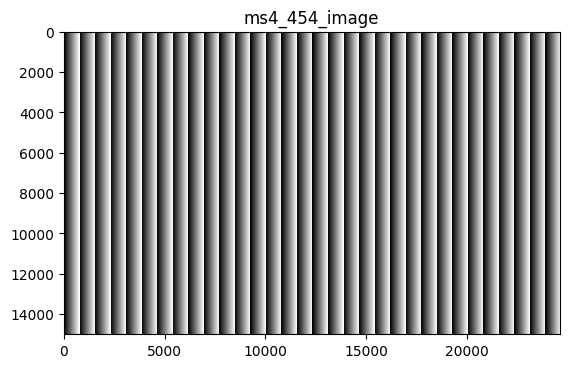

In [68]:
# 2D image
plt.figure()
plt.imshow(X=ms4_merged[:15000,:], cmap=plt.cm.gray, norm=None, aspect=None, interpolation='nearest',alpha=None, vmin=None, vmax=None, origin=None, extent=None)
title_name = f"ms4_{scenario_id}_image"
plt.title(title_name)
ms4_imshow_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms4_imshow_path, bbox_inches='tight')
plt.show()
plt.close()

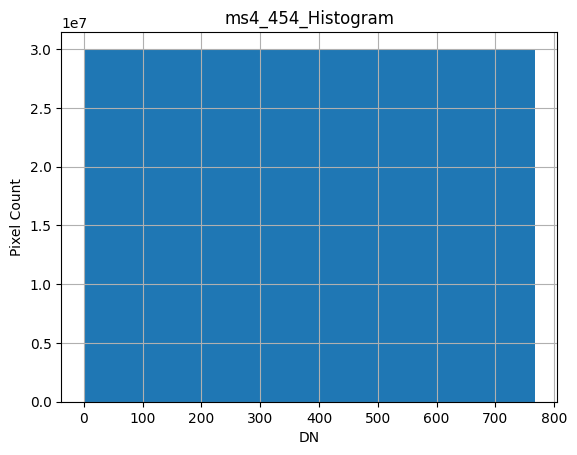

In [69]:
# histogram
plt.figure()
plt.hist(ms4_merged.ravel(),bins=32) # ravel함수 2D --> 1D, flatten()을 사용할수도 있음
plt.xlabel("DN")
plt.ylabel("Pixel Count")
title_name = f"ms4_{scenario_id}_Histogram"
plt.title(title_name)
ms4_hist_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms4_hist_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

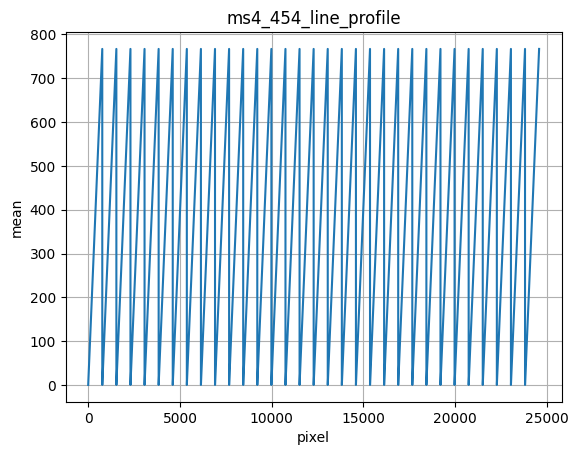

In [70]:
# Line profile
plt.figure()
plt.plot(ms4_row_mean)
plt.xlabel("pixel")
plt.ylabel("mean")
# plt.ylim(100,200)
title_name = f"ms4_{scenario_id}_line_profile"
plt.title(title_name)
ms4_line_path = folder_address + '\\'+ title_name + '.png'
plt.savefig(ms4_line_path, bbox_inches='tight')
plt.grid()
plt.show()
plt.close()

In [71]:
del ms4_merged
gc.collect()

11498

# Result Summary

In [72]:
measured_compare = pd.concat({
    "MS0": ms0_result_table.set_index("Metric")["Measured"],
    "MS1": ms1_result_table.set_index("Metric")["Measured"],
    "MS2": ms2_result_table.set_index("Metric")["Measured"],
    "MS3": ms3_result_table.set_index("Metric")["Measured"],
    "MS4": ms4_result_table.set_index("Metric")["Measured"],
}, axis=1)

measured_compare

,MS0,MS1,MS2,MS3,MS4
Metric,,,,,
Line number,38992,38984,38992,38992,38984
Pattern Check,No Error,No Error,No Error,No Error,No Error
Pass,PASS,PASS,PASS,PASS,PASS


In [73]:
if (image_source == "image"):
    passfail_compare = pd.concat({
        "MS0": ms0_result_table.set_index("Metric")["Pass"],
        "MS1": ms1_result_table.set_index("Metric")["Pass"],
        "MS2": ms2_result_table.set_index("Metric")["Pass"],
        "MS3": ms3_result_table.set_index("Metric")["Pass"],
        "MS4": ms4_result_table.set_index("Metric")["Pass"],
    }, axis=1)
else:
    passfail_compare = "N/A"
passfail_compare

'N/A'

# Save Result (Confluence)

In [74]:
# Confluence Page에 시험결과를 업로드하기 위해 아래 정보들을 입력해야 한다.
# 이미존재하는 페이지는 삭제 후 새로 생성하니 페이지 이름이 중복되지 않도록 주의해야 한다.

if (Confluence_Update_En == 1):
    # Login
    url = url
    user = user_name
    password = user_password
    confluence = Confluence(url=url, username=user, password=password)
    
    # Page Info
    space_key = space_key
    parent_page_name = parent_page_name
    parent_page_id = confluence.get_page_id(space_key, parent_page_name)
    page = folder_name
    if confluence.page_exists(space_key, page):
        id = confluence.get_page_id(space_key, page)
        confluence.remove_page(id)
    confluence.create_page(space=space_key, parent_id=parent_page_id, title=page, body="")
    page_id = confluence.get_page_id(space_key, page)

In [75]:
if (Confluence_Update_En == 1):
    header = ["Mission ID","Band","Result Summary","line diff","2D image","Histogram","Line profile"]
    contents = [
        [f"MS0",f"{scenario_id}",upload_image_in_table(space_key, page, ms0_result_path),upload_image_in_table(space_key, page, ms0_line_diff_path,image_size=100),upload_image_in_table(space_key, page, ms0_imshow_path),upload_image_in_table(space_key, page, ms0_hist_path),upload_image_in_table(space_key, page, ms0_line_path)],
        [f"MS1",f"{scenario_id}",upload_image_in_table(space_key, page, ms1_result_path),upload_image_in_table(space_key, page, ms1_line_diff_path,image_size=100),upload_image_in_table(space_key, page, ms1_imshow_path),upload_image_in_table(space_key, page, ms1_hist_path),upload_image_in_table(space_key, page, ms1_line_path)],
        [f"MS2",f"{scenario_id}",upload_image_in_table(space_key, page, ms2_result_path),upload_image_in_table(space_key, page, ms2_line_diff_path,image_size=100),upload_image_in_table(space_key, page, ms2_imshow_path),upload_image_in_table(space_key, page, ms2_hist_path),upload_image_in_table(space_key, page, ms2_line_path)],
        [f"MS3",f"{scenario_id}",upload_image_in_table(space_key, page, ms3_result_path),upload_image_in_table(space_key, page, ms3_line_diff_path,image_size=100),upload_image_in_table(space_key, page, ms3_imshow_path),upload_image_in_table(space_key, page, ms3_hist_path),upload_image_in_table(space_key, page, ms3_line_path)],
        [f"MS4",f"{scenario_id}",upload_image_in_table(space_key, page, ms4_result_path),upload_image_in_table(space_key, page, ms4_line_diff_path,image_size=100),upload_image_in_table(space_key, page, ms4_imshow_path),upload_image_in_table(space_key, page, ms4_hist_path),upload_image_in_table(space_key, page, ms4_line_path)]
    ]
    update_table(space_key, parent_page_id, page_id, page,header, contents)

# Save Result

In [76]:
# 현재 노트북 강제 저장 트리거
display({"application/json": {}}, raw=True)
# %autosave 1

In [77]:
os.system(f'jupyter nbconvert py_img_analysis.ipynb --to html --output {folder_address}/{scenario_id}_image_analysis_resutl_{t_str}.html')
if (Confluence_Update_En == 1):
     html_path = folder_address + "\\" + f"{scenario_id}_image_analysis_resutl_{t_str}.html"
     confluence.attach_file(html_path, name=None, content_type=None, page_id=page_id, title=page, space=space_key, comment=None)